## 数据处理

In [1]:
import pandas as pd
import datetime
import calendar

In [2]:
rf=pd.read_csv('SHIBOR1月.csv')
odata = pd.read_csv('上证50etf期权2015年.csv')
edata = pd.read_csv('15年ETF.csv')
test = edata

In [5]:
def get_maturity_month(i):
    date = test['date'].tolist()[i]
    ddate = datetime.datetime.strptime(date,'%Y-%m-%d')
    now_month = ddate.month
    if now_month==12:
        return '1'
    else:
        return str(now_month+1)

def cal_next_month_ForthWed(i):
    date = total['日期'].tolist()[i]
    ddate = datetime.datetime.strptime(date,'%Y-%m-%d')
    now_year = ddate.year
    now_month = ddate.month
    d = 1
    if now_month==12:
        next_month=1
        now_year=now_year+1
    else:
        next_month=now_month+1
    while(calendar.weekday(now_year,next_month,d)!=2):
        d+=1
    aim_date = datetime.date(now_year,next_month,d+21)
    return datetime.datetime.strftime(aim_date,"%Y-%m-%d")

total=pd.DataFrame()
for i in range(len(test)):
    try:
        temp=odata[odata['日期'].isin([test['date'][i]])]
        temp_list = []
        for j in range(len(temp)):
            temp_year = temp['期权简称'].tolist()[j].split('年')
            temp_month= temp_year[-1].split('月')[0]
            maturity_month = get_maturity_month(i)

            if temp_month==maturity_month:
                temp_list.append(j)
        temp = temp.iloc[temp_list,:]
        total=total.append(temp)
    except Exception:
        pass
total['ETF_price']=[test[test['date'].isin([item])]['ETF_price'].tolist()[0] for item in total['日期'].tolist()]
total['Next_Month_ForthWed']=[cal_next_month_ForthWed(i) for i in range(len(total))]
total['Time_to_Maturity']=[((datetime.datetime.strptime(total['Next_Month_ForthWed'].tolist()[i],'%Y-%m-%d')-(datetime.datetime.strptime(total['日期'].tolist()[i],'%Y-%m-%d'))).days)/365 for i in range(len(total))]
total['rf']=total['日期'].apply(lambda x:rf[rf['日期']==x]['价格'].tolist()[0]/100)

In [9]:
print(total.shape)
total.head()

(6428, 11)


,日期,交易代码,行权价,期权简称,收盘价,结算价,code,ETF_price,Next_Month_ForthWed,Time_to_Maturity,rf
68,2015-12-31,510050C1601M02350,2.35,50ETF购2016年1月2.35,0.1026,0.1026,1601,2.275,2016-01-27,0.073973,0.03002
69,2015-12-31,510050C1601M02400,2.40,50ETF购2016年1月2.40,0.0721,0.0721,1601,2.275,2016-01-27,0.073973,0.03002
70,2015-12-31,510050C1601M02450,2.45,50ETF购2016年1月2.45,0.0525,0.0525,1601,2.275,2016-01-27,0.073973,0.03002
71,2015-12-31,510050C1601M02500,2.50,50ETF购2016年1月2.50,0.0376,0.0376,1601,2.275,2016-01-27,0.073973,0.03002
72,2015-12-31,510050C1601M02550,2.55,50ETF购2016年1月2.55,0.0262,0.0262,1601,2.275,2016-01-27,0.073973,0.03002


## 波动率微笑：一个算例

In [7]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [10]:
date=total['日期'].unique().tolist()
sample=total[total['日期']==date[150]]#好像是2015年5月25号的数据
call_sample=sample[sample['期权简称'].apply(lambda x:True if '购' in x else False)==True]
put_sample=sample[sample['期权简称'].apply(lambda x:True if '沽' in x else False)==True]

In [12]:
print(call_sample.shape)
call_sample.head()

(22, 11)


,日期,交易代码,行权价,期权简称,收盘价,结算价,code,ETF_price,Next_Month_ForthWed,Time_to_Maturity,rf
21872,2015-05-25,510050C1506M02200,2.20,50ETF购2015年6月2.20,1.1021,1.1099,1506,3.11,2015-06-24,0.082192,0.02302
21873,2015-05-25,510050C1506M02250,2.25,50ETF购2015年6月2.25,1.0590,1.0576,1506,3.11,2015-06-24,0.082192,0.02302
21874,2015-05-25,510050C1506M02300,2.30,50ETF购2015年6月2.30,1.0031,1.0081,1506,3.11,2015-06-24,0.082192,0.02302
21875,2015-05-25,510050C1506M02350,2.35,50ETF购2015年6月2.35,0.9532,0.9585,1506,3.11,2015-06-24,0.082192,0.02302
21876,2015-05-25,510050C1506M02400,2.40,50ETF购2015年6月2.40,0.9110,0.9110,1506,3.11,2015-06-24,0.082192,0.02302


In [13]:
#temp存储隐含波动率；k_list存储不同行权价
temp=[];k_list=[]
#遍历每个看涨期权，计算不同报价对应的隐含波动率
for i in range(len(call_sample)):
    x=call_sample.iloc[i,:]
    s=x['ETF_price'];
    k=x['行权价'];
    rf=x['rf'];
    t=x['Time_to_Maturity']
    c=x['结算价']
    #待优化的函数
    def bsm_pricing(vol):
        d1=(np.log(s/k)+(rf+vol**2/2)*t)/(vol*np.sqrt(t))
        d2=d1-vol*np.sqrt(t)
        price=s*scipy.stats.norm.cdf(d1)-k*scipy.stats.norm.cdf(d2)*np.exp(-rf*t)
        error=price-c
        return error
    implied_vol=fsolve(bsm_pricing,0)
    temp.append(implied_vol[0])
    k_list.append(k)

g:\python\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'IV Smile')

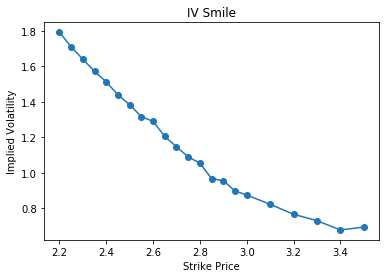

In [14]:
plt.plot(k_list,temp,'o-')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('IV Smile')

## 隐含波动率与隐含偏斜

### 计算

隐含波动率的度量与前文不同。获得每天的波动率微笑，计算隐含波动率的平均。（some type of VXO???）

隐含偏斜的度量方法比较草率。以上图为例，仅用最左边与最右边的隐含波动率做差度量。但这种方法在中国市场具有一定的可行性。

In [15]:
date=total['日期'].unique().tolist()
vol_list=[]#存储每天的隐含波动率
skew_list=[]#存储每天的隐含偏斜
#遍历每天的信息
for j in range(len(date)):
    sample=total[total['日期']==date[j]]
    call_sample=sample[sample['期权简称'].apply(lambda x:True if '购' in x else False)==True]
    put_sample=sample[sample['期权简称'].apply(lambda x:True if '沽' in x else False)==True]
    temp=[];k_list=[]
    for i in range(len(call_sample)):
        x=call_sample.iloc[i,:]
        s=x['ETF_price'];
        k=x['行权价'];
        rf=x['rf'];
        t=x['Time_to_Maturity']
        c=x['结算价']
        def bsm_pricing(vol):
            d1=(np.log(s/k)+(rf+vol**2/2)*t)/(vol*np.sqrt(t))
            d2=d1-vol*np.sqrt(t)
            price=s*scipy.stats.norm.cdf(d1)-k*scipy.stats.norm.cdf(d2)*np.exp(-rf*t)
            error=price-c
            return error
        implied_vol=fsolve(bsm_pricing,0)
        temp.append(implied_vol[0])
        k_list.append(k)
    vol_list.append(np.mean(temp))
    skew_list.append(temp[k_list.index(min(k_list))]-temp[k_list.index(max(k_list))])

g:\python\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
g:\python\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


### 画图

In [16]:
df=pd.DataFrame()
df['IV']=vol_list
df['date']=date
df=df.sort_values(by='date')
df2=pd.DataFrame()
df2['date']=date
df2['IS']=skew_list
df2=df2.sort_values(by='date')

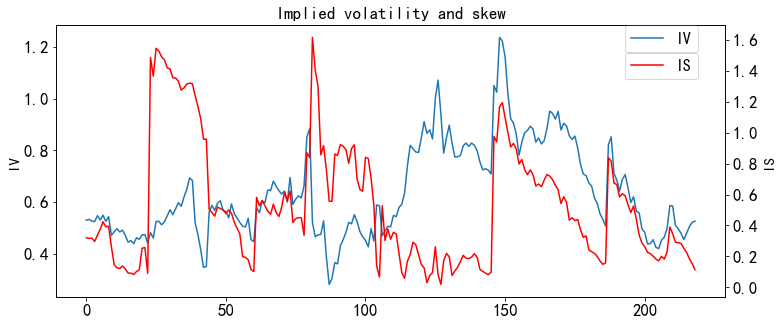

In [17]:
fig = plt.figure(figsize=(12,5))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1 = fig.add_subplot(1,1,1)
ax1.plot(df['IV'],label='IV')
#ax1.set_ylabel('每日情绪指数',fontsize=13.5)
#ax1.set_title("BI和贴水率",fontsize=16)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.ylabel('IV',fontsize=15)
plt.title('Implied volatility and skew',fontsize=17)

ax2 = ax1.twinx()  # this is the important function
ax2.plot(df2['IS'], color='r',label='IS')
#ax2.set_ylabel('贴水率',fontsize=13.5)
plt.yticks(fontsize=17)
plt.ylabel('IS',fontsize=15)

ax1.legend(loc=(0.85,0.9),fontsize=16)
ax2.legend(loc=(0.85,0.8),fontsize=16)